# Interactive image segmentation

ActinMeshure can be used to analyse data interactively. Tiff files can be read in both manually and automatically. 

In [1]:
from meshure.actimg import get_ActImg, ActImg
import numpy as np

The automatic creation of an `ActImg` instance is done using the `get_ActImg` function. It takes the name of the image file and its destination as two separate files. While this may seem cumbersome, it could be helpful to avoid using long paths when working with a directory with multiple files. 

Let's create the `actimg` instance and see what attributes are stored. 

In [2]:
actimg = get_ActImg(image_name='test_img.tif', image_dir='resources/') 
actimg.title        # image title 
actimg.resolution   # resolution (this is read in from the meta data of the tif file)
actimg.depth        # number of frames in image stack 

17

We can visualise the image using either `.visualise()` (a single frame) or `.visualise_stack()` (multiple frames) methods. Both functions accept multiple arguments; importantly, the `imtype` argument ("original" or "manipulated") specifies what to display, and `ind` or `substack` for the choice of frames (indexing starts at 1). If resolution information is available, by default, images are displayed with scale bars. 

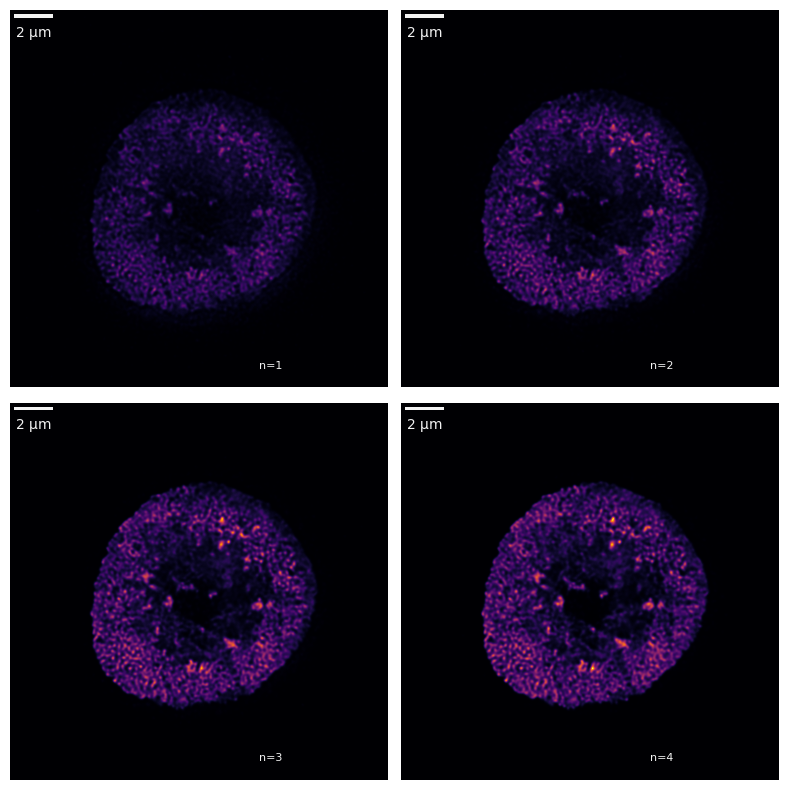

In [3]:
actimg.visualise_stack(imtype='original', substack=[1,4])   # substack=[start, stop]

Let's have a look at the basal actin mesh of this cell. This mesh is found near the cell surface. We can see this mesh from the maximum z-projection of the data. Then, we will segment the mesh structure. 

This will be done in several easy steps. Every step is applied to the data by using the appropriate method. The original data is stored under the `actimg.image_stack` attribute, while the `actimg.manipulated_stack` is updated after every operation. 

First, we'll highlight the mesh structure by applying the said maximum projection to the normalised data. Normalising the data simply rescales the values in each frame between 0-1 by the maximum pixel intensity in each frame. The visualisation knows that this is a projection of the data from frames [2-4].  

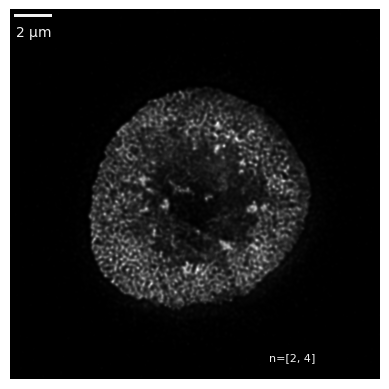

In [4]:
subs = [2,4]                            # take the frames between 2 and 4 as basal mesh 
actimg.normalise()                      # normalise the data
actimg.z_project_max(substack=subs)     # maximum projection 
actimg.visualise_stack('manipulated', colmap='gray')

However, to continue with the segmentation, we need to reset our object. There is a handy function for this. In addition, there is a hidden attribute `actimg._history`, which helps us track the operations that have been applied onto the original image stack. 

In [5]:
print(f'The history before resetting the file was: {actimg._history}')
actimg.nuke()
print(f'The history after resetting the file is:   {actimg._history}')

The history before resetting the file was: ['normalise', 'z_project_max']
The history after resetting the file is:   None


You can check that `actimg` no longer has a `manipulated_stack` attribute. Now, we can proceed with the intended segmentation. To highlight the edges of the mesh, we will apply a steerable second-order Gaussian filter. The required arguments are the orientations in which the filter will be steered ($\theta$), the standard deviation of the filter ($\sigma$), and the substack of frames onto which to apply the operation.

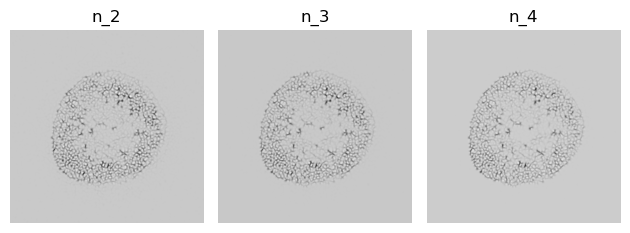

In [6]:
actimg.normalise()
                                     # orientations [0-pi] rad,                         
actimg.steerable_gauss_2order_thetas(thetas=np.linspace(0,180,21),sigma=2,substack=subs,visualise=True)

The images above are the minimum z-projection of the outputs of the filter which was steered in 21 orientations. To obtain a single image with the greatest possible signal from all three operations, we must apply a further minimum z-projection onto the results of the steerable Gaussian filter. 

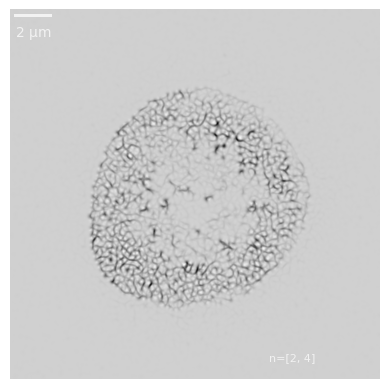

In [7]:
actimg.z_project_min()
actimg.visualise_stack('manipulated', colmap='gray')

We have a mesh structure. Now, we need a binary mask from which measurements can be taken. To this end, let's apply a binary threshold. 
This can be done using the manual `actimg.threshold()` method.

However, selecting values can be tricky, so there is a method in place which can do this for us: `actimg.threshold_dynamic()`. It takes a sample from our image and calculates the mean and standard deviation of that sample. Then, it determines a threshold and keeps all values `<= mean-std_dev_factor*std_dev`. Hence, we can use `std_dev_factor` to customise the threshold here too. 

Let's preview some cases using another handy function. The previews are superimposed with the maximum projection. 

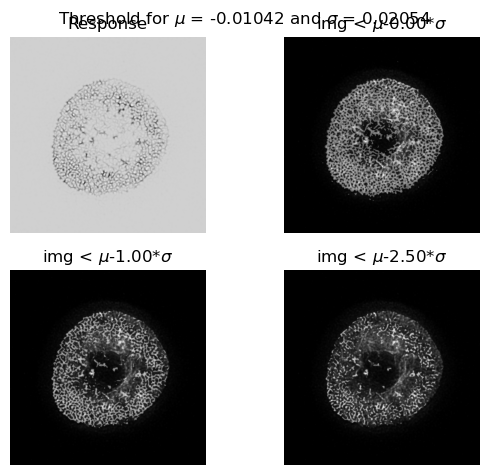

In [8]:
actimg._threshold_preview_cases(factors=[0, 1, 2.5])

Let's apply the dynamic algorithm which calculates an automatic value which is typically well-suited to the image. Now, we have a binary mask.

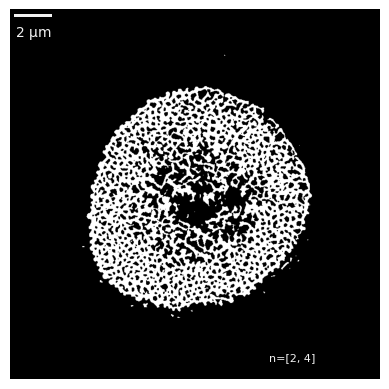

In [9]:
actimg.threshold_dynamic(std_dev_factor=0, return_mean_std_dev=False)
actimg.visualise_stack('manipulated', colmap='gray')

This binary mask can be used to extract quantitative measurements using the `ActImgBinary` class. See {ref}`Actin mesh quantification`.  